In [27]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Preparing Dataset

(Skip, if not the first time)

As the dataset is so huge, we won't work on the whole dataset for performance reason and will first work on samples of the data

In [2]:
data = pd.read_csv('./data/CleanGithubRepo_final.csv')
data.shape

(192060, 13)

## Creating a Popularity Score

A Popular Repo will have the following features --

- Increases Popularity
  - Stars
  - Forks
  - Watching
  - Downloads
  - Discussions (Indicates an active community)

- Decreases Popularity
  - Issues

- Not Necessary
  - Number of Branches
  - Pages
  - Template

- Improve QoL
  - Wiki

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
mss = MinMaxScaler(feature_range=(-10,10))
ss_fit = mss.fit_transform(data[['Stars','Forks','Issues']])
temp = pd.DataFrame(ss_fit,columns=['Stars','Forks','Issues'])

In [20]:
data['popular_score'] = (temp['Stars']+temp['Forks']) / (1+temp['Issues'])

In [21]:
data[['popular_score','Stars','Forks','Issues']].sort_values('popular_score').sample(10)

,popular_score,Stars,Forks,Issues
105603,1.992349,341,91,9
19179,0.502069,1655,39,46
34250,0.132741,1159,141,54
130325,-0.498416,267,247,70
187167,2.125866,172,15,0
82667,1.257324,449,213,18
17383,1.818182,1655,375,70
78592,1.381493,476,64,0
78769,-1.097595,475,71,70
174133,4.780155,188,24,18


In [22]:
data['popular_score'].describe()

count    192060.000000
mean          1.334073
std          11.556620
min        -140.000000
25%           0.244851
50%           1.813425
75%           2.346275
max         140.000000
Name: popular_score, dtype: float64

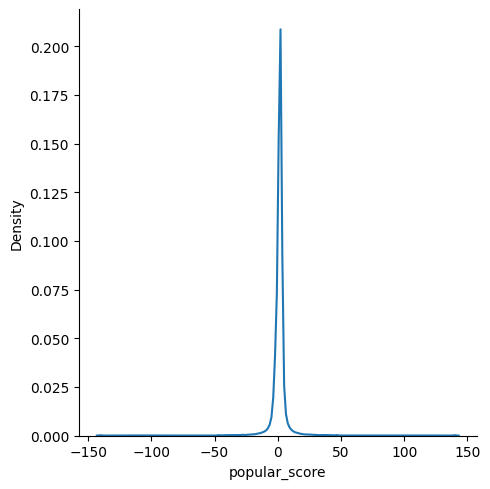

In [23]:
sns.displot(data=data,x='popular_score',kind='kde')

⚠️<span style="color:red">**Warning: Takes Very Long Time ~20min** </span>

In [ ]:
# for i,d in data.iterrows():
#     if d['popular_score'] < data['popular_score'].median():
#         data.at[i,'Popular'] = 0
#     else:
#         data.at[i,'Popular'] = 1
#     print(i)

In [24]:
corr_mat_int = data[['Popular','popular_score','Stars','Forks','Issues']].corr(method='pearson')
px.imshow(
    corr_mat_int,
    text_auto=True,
    aspect='auto',
    color_continuous_scale='purp'
)

In [17]:
data.to_csv("./data/PreparedData.csv",index=False)

We will remove all the variable from runtime, since they are not need anymore

In [25]:
%reset

# Loading Prepared Dataset

In [37]:
data = pd.read_csv("./data/PreparedData.csv")
df = data.sample(frac=.25,random_state=777)
data.shape,df.shape

((192060, 15), (48015, 15))

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48015 entries, 151491 to 561
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Size            48015 non-null  int64  
 1   Stars           48015 non-null  int64  
 2   Forks           48015 non-null  int64  
 3   Issues          48015 non-null  int64  
 4   HasIssues       48015 non-null  int64  
 5   HasDownloads    48015 non-null  int64  
 6   HasWiki         48015 non-null  int64  
 7   HasPages        48015 non-null  int64  
 8   HasDiscussions  48015 non-null  int64  
 9   DescSize        48015 non-null  float64
 10  Maintained      48015 non-null  int64  
 11  Age             48015 non-null  int64  
 12  IsPopularLang   48015 non-null  int64  
 13  popular_score   48015 non-null  float64
 14  Popular         48015 non-null  float64
dtypes: float64(3), int64(12)
memory usage: 5.9 MB


In [39]:
del data

# Unsupervised: K-Means

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [41]:
#! Takes Long Time
interia, sil = [], []
ssd = StandardScaler().fit_transform(df.drop(['Popular'],axis=1))
for i in range(2,6):
    km = KMeans(n_clusters=i)
    km.fit(ssd)
    interia.append(km.inertia_)
    sil.append(silhouette_score(ssd,km.labels_))
    print("Done K: ",i)

Done K:  2
Done K:  3
Done K:  4
Done K:  5


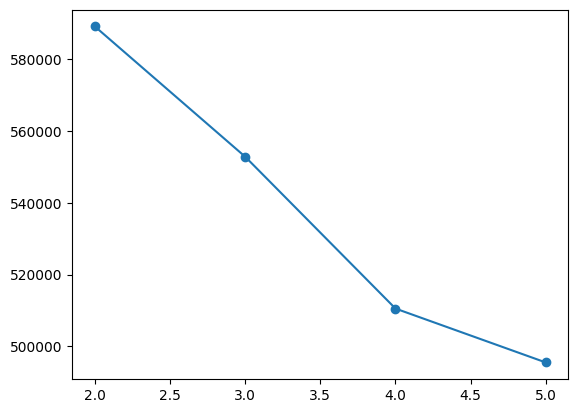

In [43]:
plt.plot(range(2,6), interia, marker = 'o')

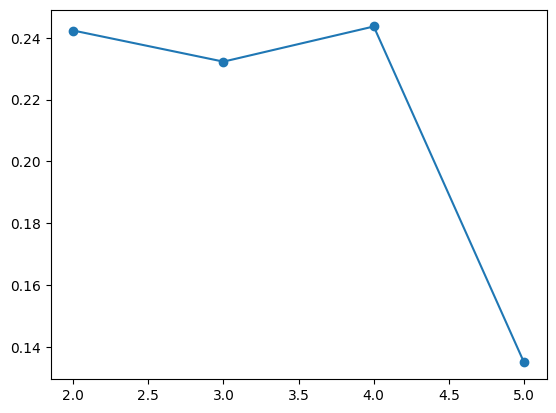

In [44]:
plt.plot(range(2,6), sil, marker = 'o')

In [45]:
km = KMeans(n_clusters=4)
pred_km = km.fit_predict(ssd)


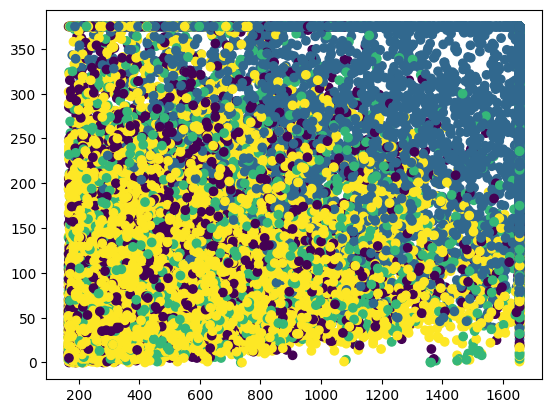

In [46]:
plt.scatter(df['Stars'],df['Forks'],c=pred_km)


In [47]:
fig = px.scatter_3d(
    x=df['Stars'][0:1000],
    y=df['Forks'][0:1000],
    z=df['Issues'][0:1000],
    color=pred_km[0:1000],
    color_continuous_scale='viridis',
    symbol=pred_km[0:1000],
    opacity=0.8
)

fig.update_layout(margin=dict(l=0,r=0,b=0,t=0))
fig.show()

# Supervised

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48015 entries, 151491 to 561
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Size            48015 non-null  int64  
 1   Stars           48015 non-null  int64  
 2   Forks           48015 non-null  int64  
 3   Issues          48015 non-null  int64  
 4   HasIssues       48015 non-null  int64  
 5   HasDownloads    48015 non-null  int64  
 6   HasWiki         48015 non-null  int64  
 7   HasPages        48015 non-null  int64  
 8   HasDiscussions  48015 non-null  int64  
 9   DescSize        48015 non-null  float64
 10  Maintained      48015 non-null  int64  
 11  Age             48015 non-null  int64  
 12  IsPopularLang   48015 non-null  int64  
 13  popular_score   48015 non-null  float64
 14  Popular         48015 non-null  float64
dtypes: float64(3), int64(12)
memory usage: 5.9 MB


In [49]:
Y = df['Popular']
X = df.drop(['Popular','popular_score'],axis=1)

In [51]:
X.shape

(48015, 13)

In [52]:
from sklearn.feature_selection import SelectKBest
bf = SelectKBest()
bf_fit = pd.DataFrame(bf.fit(X,Y).scores_)

bf_scores = pd.concat([pd.DataFrame(X.columns),bf_fit],axis=1,ignore_index=True)
bf_scores.sort_values(by=1,ascending=False)

,0,1
2,Forks,4963.245232
1,Stars,3985.621177
3,Issues,1215.341364
0,Size,446.563049
4,HasIssues,160.590575
10,Maintained,158.256742
11,Age,107.989024
12,IsPopularLang,64.227718
7,HasPages,49.844207
8,HasDiscussions,49.293343


In [113]:
X2 = df.drop(['Popular','popular_score','DescSize','HasDownloads','HasWiki','HasDiscussions','HasPages'],axis=1)
X2.shape

(48015, 8)

In [93]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=101)
X2_train,X2_test,Y2_train,Y2_test = train_test_split(X2,Y,test_size=0.2,random_state=102)

In [94]:
# Scaling

from sklearn.preprocessing import StandardScaler,MinMaxScaler
# scaler = MinMaxScaler(feature_range=(-10,10))
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = scaler.transform(X_test)

X2_train = pd.DataFrame(scaler.fit_transform(X2_train))
X2_test = scaler.transform(X2_test)

In [74]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

In [116]:
performance =[]

## Random Forest

In [75]:
from sklearn.ensemble import RandomForestClassifier

In [76]:
parameters_rf_1 = {
    "n_estimators" : [10, 20, 50, 100, 120, 150, 200, 250, 300, 350, 400, 500],
    "criterion" : ['gini', 'entropy'],
    "max_depth" : [3, 4, 5, 6, 7],
    "min_samples_split" : [2, 3]
}

In [117]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,Y_train)
rf_pred_test = rf_model.predict(X_test)

cm_rf = confusion_matrix(Y_test, rf_pred_test)
print("Accuracy: ",accuracy_score(Y_test,rf_pred_test)*100)
print("Confusion Matrix: \n", cm_rf)
print("................................")
print("Classification report \n: ", classification_report(Y_test, rf_pred_test))

Accuracy:  98.13599916692701
Confusion Matrix: 
 [[4763   62]
 [ 117 4661]]
................................
Classification report 
:                precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      4825
         1.0       0.99      0.98      0.98      4778

    accuracy                           0.98      9603
   macro avg       0.98      0.98      0.98      9603
weighted avg       0.98      0.98      0.98      9603



In [96]:
rf_model = RandomForestClassifier()
rf_model.fit(X2_train,Y2_train)
rf_pred_test = rf_model.predict(X2_test)

cm_rf = confusion_matrix(Y2_test, rf_pred_test)

print("Accuracy: ",accuracy_score(Y2_test,rf_pred_test)*100)
print("Confusion Matrix: \n", cm_rf)
print("................................")
print("Classification report \n: ", classification_report(Y2_test, rf_pred_test))

Accuracy:  98.38592106633344
Confusion Matrix: 
 [[4747   51]
 [ 104 4701]]
................................
Classification report 
:                precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      4798
         1.0       0.99      0.98      0.98      4805

    accuracy                           0.98      9603
   macro avg       0.98      0.98      0.98      9603
weighted avg       0.98      0.98      0.98      9603



## XGBoost

In [97]:
from xgboost import XGBClassifier

In [99]:
xgb = XGBClassifier(random_state=1119)
xgb.fit(X_train,Y_train)
xgb_pred_test = xgb.predict(X_test)


cm_xgb = confusion_matrix(Y_test, xgb_pred_test)

print("Accuracy: ",accuracy_score(Y_test,xgb_pred_test)*100)
print("Confusion Matrix: \n", cm_xgb)
print("................................")
print("Classification report \n: ", classification_report(Y_test, xgb_pred_test))

Accuracy:  99.21899406435489
Confusion Matrix: 
 [[4791   34]
 [  41 4737]]
................................
Classification report 
:                precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4825
         1.0       0.99      0.99      0.99      4778

    accuracy                           0.99      9603
   macro avg       0.99      0.99      0.99      9603
weighted avg       0.99      0.99      0.99      9603



In [104]:
xgb = XGBClassifier(random_state=1119)
xgb.fit(X2_train,Y2_train)
xgb_pred_test = xgb.predict(X2_test)


cm_xgb = confusion_matrix(Y2_test, xgb_pred_test)

print("Accuracy: ",accuracy_score(Y2_test,xgb_pred_test)*100)
print("Confusion Matrix: \n", cm_xgb)
print("................................")
print("Classification report \n: ", classification_report(Y2_test, xgb_pred_test))

Accuracy:  99.2814745392065
Confusion Matrix: 
 [[4767   31]
 [  38 4767]]
................................
Classification report 
:                precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4798
         1.0       0.99      0.99      0.99      4805

    accuracy                           0.99      9603
   macro avg       0.99      0.99      0.99      9603
weighted avg       0.99      0.99      0.99      9603



## Logistic Regression

In [105]:
from sklearn.linear_model import LogisticRegression

In [106]:
lr = LogisticRegression()
lr.fit(X_train,Y_train)

lr_pred = lr.predict(X_test)

cm_lr = confusion_matrix(Y_test, lr_pred)

print("Accuracy: ",accuracy_score(Y_test,lr_pred)*100)
print("Confusion Matrix: \n", cm_lr)
print("................................")
print("Classification report \n: ", classification_report(Y_test, lr_pred))

Accuracy:  68.77017598667084
Confusion Matrix: 
 [[2654 2171]
 [ 828 3950]]
................................
Classification report 
:                precision    recall  f1-score   support

         0.0       0.76      0.55      0.64      4825
         1.0       0.65      0.83      0.72      4778

    accuracy                           0.69      9603
   macro avg       0.70      0.69      0.68      9603
weighted avg       0.70      0.69      0.68      9603



In [107]:
lr = LogisticRegression()
lr.fit(X2_train,Y2_train)

lr_pred = lr.predict(X2_test)

cm_lr = confusion_matrix(Y2_test, lr_pred)

print("Accuracy: ",accuracy_score(Y2_test,lr_pred)*100)
print("Confusion Matrix: \n", cm_lr)
print("................................")
print("Classification report \n: ", classification_report(Y2_test, lr_pred))

Accuracy:  69.64490263459335
Confusion Matrix: 
 [[2696 2102]
 [ 813 3992]]
................................
Classification report 
:                precision    recall  f1-score   support

         0.0       0.77      0.56      0.65      4798
         1.0       0.66      0.83      0.73      4805

    accuracy                           0.70      9603
   macro avg       0.71      0.70      0.69      9603
weighted avg       0.71      0.70      0.69      9603



## ADABoost

In [108]:
from sklearn.ensemble import AdaBoostClassifier

In [109]:
adab = AdaBoostClassifier()
adab.fit(X_train,Y_train)
adab_pred = adab.predict(X_test)
cm_adab = confusion_matrix(Y_test,adab_pred)
print("Accuracy: ",accuracy_score(Y_test,adab_pred)*100)
print("Confusion Matrix: \n", cm_adab)
print("................................")
print("Classification report \n: ", classification_report(Y_test, adab_pred))

d:\Uzair\1 Projects\GitRepo-Analysis\env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



Accuracy:  80.39154430907008
Confusion Matrix: 
 [[3933  892]
 [ 991 3787]]
................................
Classification report 
:                precision    recall  f1-score   support

         0.0       0.80      0.82      0.81      4825
         1.0       0.81      0.79      0.80      4778

    accuracy                           0.80      9603
   macro avg       0.80      0.80      0.80      9603
weighted avg       0.80      0.80      0.80      9603



In [110]:
adab = AdaBoostClassifier()
adab.fit(X2_train,Y2_train)
adab_pred = adab.predict(X2_test)
cm_adab = confusion_matrix(Y2_test,adab_pred)
print("Accuracy: ",accuracy_score(Y2_test,adab_pred)*100)
print("Confusion Matrix: \n", cm_adab)
print("................................")
print("Classification report \n: ", classification_report(Y2_test, adab_pred))

d:\Uzair\1 Projects\GitRepo-Analysis\env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



Accuracy:  79.95418098510882
Confusion Matrix: 
 [[3919  879]
 [1046 3759]]
................................
Classification report 
:                precision    recall  f1-score   support

         0.0       0.79      0.82      0.80      4798
         1.0       0.81      0.78      0.80      4805

    accuracy                           0.80      9603
   macro avg       0.80      0.80      0.80      9603
weighted avg       0.80      0.80      0.80      9603



## SVM

In [111]:
from sklearn.svm import SVC

In [68]:
sv = SVC(kernel='rbf',random_state=42)
sv.fit(X_train,Y_train)
sv_pred = sv.predict(X_test)
cm_sv = confusion_matrix(Y_test,sv_pred)
print("Accuracy: ",accuracy_score(Y_test,sv_pred)*100)
print("Confusion Matrix: \n", cm_sv)
print("................................")
print("Classification report \n: ", classification_report(Y_test, sv_pred))

Accuracy:  93.81443298969072
Confusion Matrix: 
 [[4457  368]
 [ 226 4552]]
................................
Classification report 
:                precision    recall  f1-score   support

         0.0       0.95      0.92      0.94      4825
         1.0       0.93      0.95      0.94      4778

    accuracy                           0.94      9603
   macro avg       0.94      0.94      0.94      9603
weighted avg       0.94      0.94      0.94      9603



In [112]:
sv = SVC(kernel='rbf',random_state=42)
sv.fit(X2_train,Y2_train)
sv_pred = sv.predict(X2_test)
cm_sv = confusion_matrix(Y2_test,sv_pred)
print("Accuracy: ",accuracy_score(Y2_test,sv_pred)*100)
print("Confusion Matrix: \n", cm_sv)
print("................................")
print("Classification report \n: ", classification_report(Y2_test, sv_pred))

Accuracy:  96.16786420910132
Confusion Matrix: 
 [[4573  225]
 [ 143 4662]]
................................
Classification report 
:                precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      4798
         1.0       0.95      0.97      0.96      4805

    accuracy                           0.96      9603
   macro avg       0.96      0.96      0.96      9603
weighted avg       0.96      0.96      0.96      9603



---
# Conclusion

---